In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import glob
import os

from matplotlib import pyplot as plt
from sklearn.cluster import SpectralCoclustering
import itertools
import matplotlib
import calpgs
from admix.data import pval2chisq, zsc2pval
import sys
from scipy import stats
from calpgs import compare_values

sys.path.append("../r2-diff/")

from utils import load_r2_result, plot_heatmap, plot_heatmap2

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

# Load meta data

In [2]:
DATA_DIR = "../compile-data/out/per-trait-info/"
DATA_URL = "../r2-diff/data-table.xlsx"

df_trait_info = pd.read_excel(DATA_URL, sheet_name=0)
trait_map = {
    row.id: row.short if row.short is not np.nan else row.description
    for _, row in df_trait_info.iterrows()
}

df_covar_info = pd.read_excel(DATA_URL, sheet_name=1)
covar_map = {row.id: row.short for _, row in df_covar_info.iterrows()}

df_display = pd.read_excel(DATA_URL, sheet_name=2)

ALL_TRAIT_LIST = trait_map.keys()
MAIN_TRAIT_LIST = df_display.id.values
MAIN_COVAR_LIST = covar_map.keys()

In [3]:
COVAR_COLS = [
    "AGE",
    "SEX",
    "DEPRIVATION_INDEX",
    "log_BMI",
    "income",
    "ever_smoked",
    "drink_alcohol",
    "glasses",
    "years_of_edu",
] + [f"PC{i}" for i in range(1, 5)]
FIT_COLS = ["PGS"] + COVAR_COLS

# Load data

In [4]:
dict_df_sigma = dict()
for method in ["marginal", "joint", "joint+slope"]:
    for group in ["white", "other"]:
        dict_df_sigma[method, group] = pd.read_csv(
            f"out/fit-summary/{method}-{group}.gamma.tsv", sep="\t", index_col=0
        )

dict_df_slope = dict()
dict_df_r2 = dict()

for group in ["white", "other"]:
    dict_df_slope[group] = pd.read_csv(
        f"out/fit-summary/joint+slope-{group}.slope.tsv", sep="\t", index_col=0
    )
    dict_df_r2[group] = load_r2_result("../r2-diff/out/", group)[3].loc[
        :, MAIN_TRAIT_LIST
    ]

# Consistency between two set of results

## Overview

In [9]:
annotate_list = [("SEX", "log_BMI"), ("SEX", "height"), ("glasses", "myopia")]

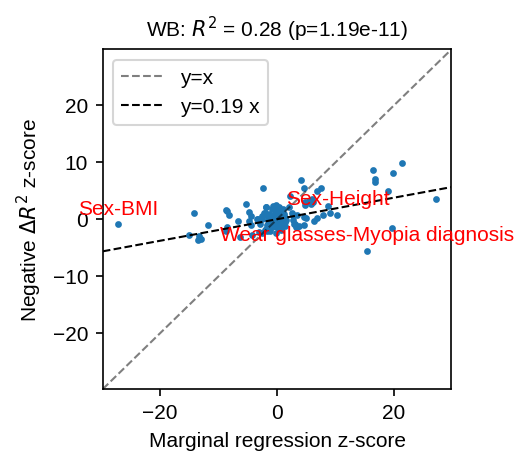

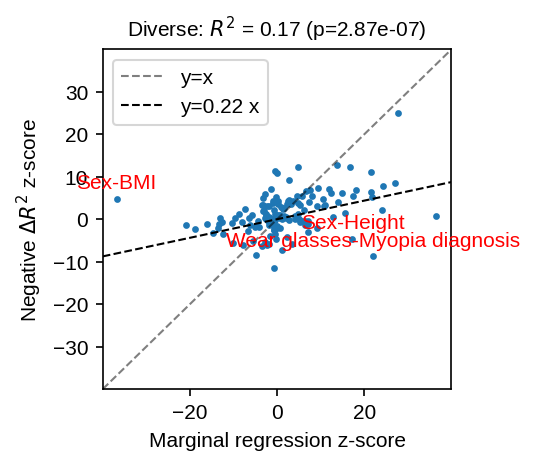

In [10]:
for group in ["white", "other"]:
    df_r2 = dict_df_r2[group]
    df_sigma = dict_df_sigma["marginal", group]
    df_slope = dict_df_slope[group]

    tmp_covar_list = list(set(df_slope.index) & set(df_r2.index))
    df_r2 = (-1) * df_r2.loc[tmp_covar_list, MAIN_TRAIT_LIST]
    df_sigma = df_sigma.loc[tmp_covar_list, MAIN_TRAIT_LIST]
    df_slope = df_slope.loc[tmp_covar_list, MAIN_TRAIT_LIST]

    fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
    x, y = df_sigma.values.flatten(), df_r2.values.flatten()
    notnan_idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[notnan_idx], y[notnan_idx]
    compare_values(
        x=x,
        y=y,
        xlabel="Marginal regression z-score",
        ylabel="Negative $\Delta R^2$ z-score",
    )
    for annot in annotate_list:

        ax.annotate(
            covar_map[annot[0]] + "-" + trait_map[annot[1]],
            xy=(df_sigma.loc[annot], df_r2.loc[annot]),
            xytext=(0, 5),
            color="red",
            textcoords="offset points",
            ha="center",
        )

    name = {"white": "WB", "other": "Diverse"}[group]
    ax.set_title(
        f"{name}: $R^2$ = {stats.pearsonr(x, y)[0] ** 2:.2g} (p={stats.pearsonr(x, y)[1]:.3g})",
        fontsize=10,
    )

## Parameteric test

In [11]:
for group in ["white", "other"]:
    df_sigma = dict_df_sigma["joint+slope", group] * (-1)

    display(
        df_sigma.loc[MAIN_COVAR_LIST, MAIN_TRAIT_LIST]
        .rename(index=covar_map, columns=trait_map)
        .style.background_gradient(axis=None, vmin=-5, vmax=5, cmap="bwr")
        .format(precision=2)
        .set_caption("Group: " + group)
    )

,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Systolic BP,Height,BMI,Neuroticism,Edu years
Age,-18.86,-17.94,-13.77,4.20,0.07,2.21,-24.30,2.51,8.89,11.25,3.84
Sex,-4.06,-4.76,-6.99,-3.13,-7.93,-0.11,6.21,-10.03,25.69,2.72,0.67
PC1,-0.94,-0.56,-0.28,0.06,-0.97,-0.52,0.74,0.12,0.17,-0.00,0.49
PC2,0.25,-0.61,1.12,-0.04,-1.55,-0.85,0.10,-1.48,-1.09,1.09,0.01
Smoking,-3.42,-2.69,-3.56,-6.35,-3.96,1.08,0.86,0.41,0.15,-3.50,-0.75
Alcohol,1.79,1.41,0.65,3.69,1.83,0.47,0.53,-0.14,5.70,1.57,-0.87
BMI,-14.28,-15.18,-15.64,9.69,16.52,1.21,-0.96,-1.58,nan,0.53,-2.17
Wear glasses,0.63,0.29,0.31,2.50,3.54,-18.32,-0.10,0.74,-3.19,-2.21,0.84
Income,6.61,6.53,7.44,6.22,3.53,-2.13,2.74,3.57,9.94,9.40,7.43
Deprivation index,-2.62,-2.07,-2.81,-5.17,-3.29,-0.73,-0.66,-5.02,-15.35,-5.14,2.53


,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Systolic BP,Height,BMI,Neuroticism,Edu years
Age,-25.24,-23.10,-20.12,4.09,1.11,3.22,-34.36,5.50,12.92,13.06,4.19
Sex,-9.66,-10.02,-11.74,-1.99,-8.26,1.15,6.61,-15.83,35.35,3.60,2.03
PC1,-14.01,-11.53,-17.18,-10.05,-9.43,1.05,-14.29,-20.37,2.30,3.62,2.06
PC2,0.94,0.60,2.86,-9.08,-8.63,1.90,0.79,0.98,-9.30,5.78,-3.30
Smoking,-4.11,-3.33,-5.27,-9.23,-3.29,-0.03,1.83,1.69,-2.92,-2.89,-0.88
Alcohol,1.77,1.13,2.08,2.21,0.34,-3.51,1.21,-0.80,7.43,1.00,-0.30
BMI,-16.61,-16.97,-18.49,12.63,19.53,-0.09,1.35,-0.20,nan,-0.56,-3.74
Wear glasses,0.22,-0.17,-0.90,-1.76,-0.26,-25.59,-1.25,-1.25,-4.31,-5.23,0.93
Income,6.20,5.98,6.31,3.64,5.63,-4.49,7.20,4.09,13.96,10.62,15.60
Deprivation index,-2.44,-3.31,-2.56,-7.66,-5.68,0.69,-1.76,-9.28,-14.45,-5.40,5.39


## R2 difference

In [12]:
for group in ["white", "other"]:

    df_r2 = dict_df_r2[group]

    display(
        df_r2.loc[MAIN_COVAR_LIST, MAIN_TRAIT_LIST]
        .rename(index=covar_map, columns=trait_map)
        .style.background_gradient(axis=None, vmin=-5, vmax=5, cmap="bwr")
        .format(precision=2)
        .set_caption("Group: " + group)
    )

trait,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Systolic BP,Height,BMI,Neuroticism,Edu years
group,,,,,,,,,,,
Age,-9.82,-8.11,-8.56,-1.35,0.71,0.42,-3.59,-2.22,-1.57,1.36,-5.52
Sex,-6.92,-5.42,-5.47,-0.71,-4.93,-0.41,-2.62,-0.78,0.91,-0.49,-2.39
PC1,0.92,0.21,0.97,-0.59,-1.46,0.19,0.11,0.84,0.02,0.01,0.90
PC2,-1.07,-0.36,-1.03,-0.13,0.12,-0.75,-1.17,-0.98,0.15,0.21,0.45
Smoking,-3.28,-2.41,-3.10,-0.25,-0.13,-0.87,-2.45,-0.64,-1.02,-0.73,-0.45
Alcohol,2.31,2.39,2.08,0.89,1.43,-0.27,-0.12,-0.92,-1.39,-0.96,1.64
BMI,-7.12,-6.57,-5.02,2.05,2.77,-0.58,-4.13,-1.16,3.78,-0.55,-2.17
Wear glasses,-3.55,-2.72,-3.00,0.31,1.03,5.59,-1.03,1.89,1.14,1.33,-2.15
Income,3.72,3.42,2.94,0.28,-0.05,1.41,1.06,0.13,-1.15,-0.75,3.12


trait,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Systolic BP,Height,BMI,Neuroticism,Edu years
group,,,,,,,,,,,
Age,-8.42,-7.69,-5.31,2.69,-1.14,-0.29,-0.70,5.50,-0.24,-0.20,-4.87
Sex,-7.24,-4.79,-6.27,-2.72,-5.39,0.76,-2.30,4.55,-4.71,-1.87,-3.14
PC1,-11.23,-10.83,-12.15,-12.16,-7.21,-5.92,-6.78,-24.97,-12.68,-5.29,-9.33
PC2,0.69,-0.31,0.14,-3.44,-4.12,-0.33,-2.77,-6.68,-1.35,-0.87,-0.10
Smoking,0.37,0.67,1.40,2.16,-0.12,2.10,-1.99,5.26,0.34,-0.69,4.59
Alcohol,6.08,5.77,6.21,2.60,1.56,5.72,1.49,8.32,3.59,1.78,11.37
BMI,-6.97,-5.34,-6.36,-1.23,1.24,-0.52,-4.24,-5.51,6.91,-0.69,-3.83
Wear glasses,-2.19,-3.36,-1.24,1.39,0.04,8.75,-0.52,1.77,2.17,-0.12,-0.91
Income,1.11,0.74,2.00,1.46,-0.22,2.96,2.38,5.08,1.43,0.96,3.26


In [13]:
for group in ["white", "other"]:

    df_slope = dict_df_slope[group]

    display(
        df_slope.loc[MAIN_COVAR_LIST, MAIN_TRAIT_LIST]
        .rename(index=covar_map, columns=trait_map)
        .style.background_gradient(axis=None, vmin=-5, vmax=5, cmap="bwr")
        .format(precision=2)
        .set_caption("Group: " + group)
    )

,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Systolic BP,Height,BMI,Neuroticism,Edu years
Age,-113.50,-134.35,-115.29,-49.57,-8.25,3.08,-32.60,2.27,-96.21,2.86,-28.28
Sex,-100.08,-119.86,-85.33,138.49,-14.71,1.24,-147.32,-7.84,-128.55,20.23,90.70
PC1,-2.84,-2.99,-1.56,7.14,-1.03,-0.39,-8.37,-12.62,-0.09,2.18,-1.12
PC2,-1.58,-1.28,-1.76,1.63,-1.44,0.81,-3.63,14.76,-8.39,4.13,-2.47
Smoking,-3.93,-2.80,-3.19,-15.20,0.51,1.94,14.84,-23.73,27.38,-0.09,9.49
Alcohol,7.26,8.13,5.36,-3.50,2.13,-0.68,3.64,-2.42,13.10,-2.28,7.21
BMI,-72.40,-73.25,-66.97,3.53,-6.46,-0.83,5.03,39.38,nan,5.31,10.11
Wear glasses,1.93,1.32,2.72,-12.87,3.03,69.81,-8.00,-1.19,-2.68,-2.03,-0.91
Income,14.15,13.60,13.37,-18.30,1.90,-1.32,5.27,52.29,43.52,-8.36,17.67
Deprivation index,-10.59,-10.26,-10.41,-6.53,1.52,1.22,4.56,-15.50,5.66,-1.87,14.62


,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Systolic BP,Height,BMI,Neuroticism,Edu years
Age,-170.46,-199.72,-170.01,-11.92,-12.69,11.22,-45.31,-62.22,-66.38,-10.32,-45.91
Sex,-131.37,-158.66,-113.25,35.07,-19.96,-1.07,-189.65,-66.58,-375.95,-8.59,18.43
PC1,-24.20,-25.52,-18.25,160.00,-4.84,0.10,-13.00,-248.96,-165.21,-8.36,-56.77
PC2,34.90,35.92,29.89,32.67,0.74,-1.56,9.96,35.84,16.40,-0.19,55.29
Smoking,-2.08,-1.73,1.26,-10.00,-0.35,-0.83,5.01,0.21,-9.78,13.71,-1.96
Alcohol,15.07,16.25,15.19,-16.15,1.52,2.79,25.10,5.95,28.29,6.23,11.51
BMI,-82.41,-83.56,-79.06,30.07,-1.29,1.09,-19.50,36.19,nan,0.33,-2.99
Wear glasses,-12.05,-13.01,-12.31,0.55,-1.39,83.39,-9.42,14.77,-8.23,5.67,-6.36
Income,13.34,13.95,11.49,-21.30,1.65,2.06,-2.47,43.62,36.12,-16.70,5.73
Deprivation index,-16.48,-16.46,-13.15,19.79,-0.62,0.51,-6.13,-29.22,-23.81,0.23,-4.56


# Consistency between WB and diverse individuals


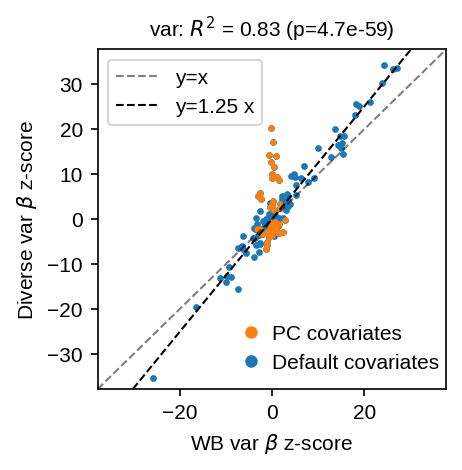

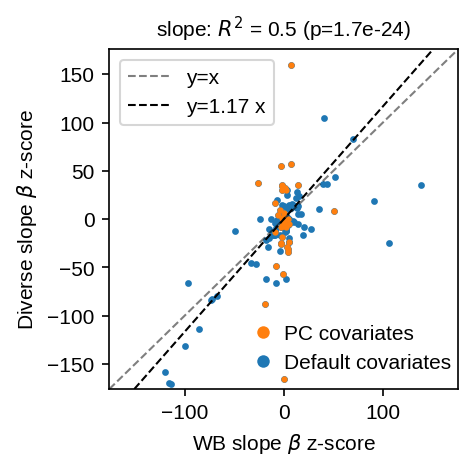

In [14]:
for name in ["var", "slope"]:
    if name == "var":
        df1 = dict_df_sigma["joint+slope", "white"]
        df2 = dict_df_sigma["joint+slope", "other"]
    elif name == "slope":
        df1 = dict_df_slope["white"]
        df2 = dict_df_slope["other"]
    else:
        raise NotImplementedError

    fig, ax = plt.subplots(figsize=(3, 3), dpi=150)

    from matplotlib.lines import Line2D

    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="C1",
            label="PC covariates",
            markersize=7,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="C0",
            label="Default covariates",
            markersize=7,
        ),
    ]
    scatter_legend = ax.legend(
        handles=legend_elements,
        bbox_to_anchor=(0.68, 0.12),
        loc="center",
        frameon=False,
        handletextpad=0.02,
    )

    x, y = df1.values.flatten(), df2.values.flatten()
    notnan_idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[notnan_idx], y[notnan_idx]

    compare_values(
        x=x,
        y=y,
        xlabel=fr"WB {name} $\beta$ z-score",
        ylabel=fr"Diverse {name} $\beta$ z-score",
    )

    # plot PC
    ax.scatter(
        df1.loc[df1.index.str.startswith("PC"), :],
        df2.loc[df2.index.str.startswith("PC"), :],
        s=4,
        label="PC covariates",
    )
    ax.set_title(
        f"{name}: $R^2$ = {stats.pearsonr(x, y)[0] ** 2:.2g} (p={stats.pearsonr(x, y)[1]:.2g})",
        fontsize=10,
    )

    plt.gca().add_artist(scatter_legend)
    fig.show()